In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import io
import json
from sklearn.cluster import KMeans

This part will copy the data from statsbomb into the local folder structure. It can be found under `content/open-data/`. It is only neccessary to run this code once, not everytime you restart the notebook.

In [ ]:
!git clone https://github.com/statsbomb/open-data.git

In [ ]:
raw_data = []
path = '/content/open-data/data/events'
#700: ok, >3/4 RAM used
# 100: good runtime to check if changes work
for x in os.listdir(path)[:700]:                       
  with open(os.path.join(path, x), "r") as f:
    raw_data.append(json.loads(f.read()))
    f.close()
print(raw_data[0])

In [ ]:
# upload one file, step 1/2
#from google.colab import files
#uploaded = files.upload()

Saving 15946.json to 15946.json


In [ ]:
## upload 1 file, step 2/2
#raw_data = []
#for file_name in uploaded.keys():
#  io.StringIO(uploaded[file_name].decode("utf-8"))
#  raw_data.append(json.loads(uploaded[file_name].decode("utf-8")))

In [ ]:
# to test if data was uploaded correctly
for k in range(0, len(raw_data)): 
  for i in range(0,5):
    print(raw_data[k][i])

In [ ]:
# dataframe with index, x & y coordinates
df = pd.DataFrame(columns=['index', 'x-coord', 'y-coord', "event name"])
#index, x & y coord  
for k in range(0, len(raw_data)):
  arr = np.zeros([len(raw_data[k]), 3])
  event_name = []
  for i in range(0, len(raw_data[k])):
    row = raw_data[k][i] 
    arr[i, 0] = row.get('index')
    if 'location' in row:
      arr[i, 1] = raw_data[k][i]['location'][0]
      arr[i, 2] = raw_data[k][i]['location'][1]
    # set [-1, -1] as coordinates for events without location
    else:
      arr[i, 1] = -1
      arr[i, 2] = -1
    event_name.append(raw_data[k][i]['type']['name'])

  one_game_df = pd.DataFrame(arr, columns=['index', 'x-coord', 'y-coord'])
  one_game_df['event name'] = event_name
  df = df.append(one_game_df,ignore_index=True)

print(df)

          index  x-coord  y-coord     event name
0           1.0     -1.0     -1.0    Starting XI
1           2.0     -1.0     -1.0    Starting XI
2           3.0     -1.0     -1.0     Half Start
3           4.0     -1.0     -1.0     Half Start
4           5.0     60.0     40.0           Pass
...         ...      ...      ...            ...
2515638  3013.0     13.8     35.9  Ball Recovery
2515639  3014.0     13.8     35.9          Carry
2515640  3015.0     17.4     51.4           Pass
2515641  3016.0     -1.0     -1.0       Half End
2515642  3017.0     -1.0     -1.0       Half End

[2515643 rows x 4 columns]


In [ ]:
# make sub-array for clustering & plotting
eightD = []
goal = [119, 35] # goal coordinates

counter = 0 
#select events
for i in range(0, len(df.index)-6): 
  if df.loc[i, 'event name'] == 'Pass' and df.loc[i+2, 'event name'] == 'Pass' \
  and df.loc[i+4, 'event name'] == 'Shot' and df.loc[i+1, 'event name'] == 'Ball Receipt*' \
  and df.loc[i+3, 'event name'] == 'Ball Receipt*':
    counter+=1
    print(counter)
  
  # add events needed for clustering & plotting
    sub_list = [] #(re)initialize list
    sub_list.append(df.loc[i, "x-coord"]) #1st pass
    sub_list.append(df.loc[i, "y-coord"])
    sub_list.append(df.loc[i+2, "x-coord"]) # 2nd pass
    sub_list.append(df.loc[i+2, "y-coord"])
    sub_list.append(df.loc[i+4, "x-coord"]) # shot
    sub_list.append(df.loc[i+4, "y-coord"])
    sub_list.append(goal[0]) # ball in the goal
    sub_list.append(goal[1])
  
    eightD.append(sub_list)

# convert list of lists to np.array      
eightD = np.array(eightD) 


In [ ]:
# clustering
nb_clus = 8
kmeans = KMeans(n_clusters=nb_clus, random_state=0).fit(eightD)
y_kmeans = kmeans.predict(eightD)
print(y_kmeans)
print(len(y_kmeans))

[7 1 2 0 3 0 1 7 7 6 3 1 7 7 3 7 4 7 6 7 1 3 3 3 7 7 6 6 3 6 2 3 1 0 6 1 1
 1 6 3 6 1 0 1 3 5 5 1 7 3 3 0 1 6 4 1 2 2 1 3 7 0 6 3 3 1 7 1 6 7 4 4 6 1
 2 4 6 1 0 2 1 4 6 7 1 4 4 6 5 5 6 3 0 5 1 7 7 6 1 0 5 3 3 0 7 7 6 3 6 7 3
 6 6 1 3 4 3 0 1 4 3 6 6 3 7 0 7 6 5 4 3 7 0 5 3 1 1 2 7 6 1 6 5 1 7 6 6 1
 6 4 6 7 5 4 6 1 1 3 3 1 7 5 7 1 1 6 6 4 3 5 6 6 3 6 1 7 1 0 1 1 0 6 3 4 7
 4 4 4 6 0 3 1 3 2 0 7 6 2 0 4 7 7 1 1 1 6 3 1 0 6 6 7 7 1 6 3 6 1 1 6 1 1
 3 1 2 4 5 6 6 6 6 7 6 6 0 3 6 6 2 0 1 7 3 6 3 3 1 2 7 7 1 3 5 7 4 7 6 7 6
 7]
260


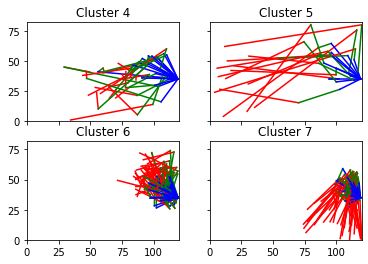

In [ ]:
#plotting clusters
x_values = []
y_values = []

fig, axs = plt.subplots(2, 2)

# upper row, plots clusters 4 & 5
# to plot other clusters, change values in range of outer for-loop & axs[]
for i in range(4, 6):
  for k in range(0, len(y_kmeans)):
    if y_kmeans[k] == i:
      c = ['r', 'g', 'b']
      #select values to plot from array 
      x_values = [eightD[k][0], eightD[k][2], eightD[k][4], eightD[k][6]]
      y_values = [eightD[k][1], eightD[k][3], eightD[k][5], eightD[k][7]]
      for l in range(3):
        # 1st pass in red, 2nd in green, shot in blue
        axs[0, i-4].plot(x_values[l:l+2], y_values[l:l+2], color=c[l])
      title = 'Cluster ' + str(i)
      axs[0, i-4].set_title(title)

#lower row, plots clusters 6 & 7
for i in range(6, 8):
  for k in range(0, len(y_kmeans)):
    if y_kmeans[k] == i:
      c = ['r', 'g', 'b']
      x_values = [eightD[k][0], eightD[k][2], eightD[k][4], eightD[k][6]]
      y_values = [eightD[k][1], eightD[k][3], eightD[k][5], eightD[k][7]]
      for l in range(3):
        axs[1, i-6].plot(x_values[l:l+2], y_values[l:l+2], color=c[l])
      title = 'Cluster ' + str(i)
      axs[1, i-6].set_title(title)

# makes graphs more readable
for ax in axs.flat:
    ax.label_outer()
    ax.set(xlim=(0, 120), ylim=(0, 82))


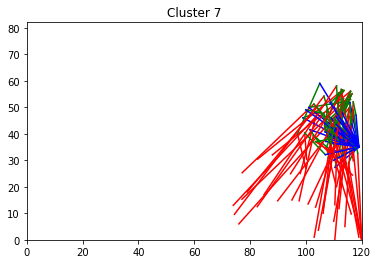

In [ ]:
#plotting  1 cluster
x_values = []
y_values = []

cluster = 7

for k in range(0, len(y_kmeans)):
  if y_kmeans[k] == cluster:
    c = ['r', 'g', 'b']
    x_values = [eightD[k][0], eightD[k][2], eightD[k][4], eightD[k][6]]
    y_values = [eightD[k][1], eightD[k][3], eightD[k][5], eightD[k][7]]
    plt.xlim([0, 120])
    plt.ylim([0, 82])
    for l in range(3):
      plt.plot(x_values[l:l+2], y_values[l:l+2], color=c[l])
    title = 'Cluster ' + str(cluster)
    plt.title(title)
    #plt.plot(x_values, y_values)